In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt


# Tutorial: VQE for arbitrary Hamiltonian ground state energy simulation on the Rigetti Forest platform
In this python notebook tutorial, we present a basic introduction to using the Qu & Co VQE app for simulating the groundstate energy of an arbitrary Hamiltonian, on the Rigetti Forest quantum computing platform. In this notebook, we show how to load a problem Hamiltonian, how to configure the VQE instance, set up your custom circuit and visualize the results from the calculations.

To run this notebook on your local machine, please install the Rigetti Forest SDK (detailed instructions [here](http://docs.rigetti.com/en/stable/start.html)) and run <code class="markup--code markup--p-code">QVM -S </code> and  <code class="markup--code markup--p-code"> quilc -R </code> in your terminal.
If you want to run your code on the QCS, please refer to [Rigetti's qcs page](https://www.rigetti.com/qcs/docs/intro-to-qcs).

The goal in this example is to minimize a given Hamiltonian cost function over the Hilbert space. For simplicity, we directly write the Hamiltonian in terms of qubit operators (in general, many Fermionic, bosonic and binary optimization problems can be written in terms of Pauli spin operators.)

In [2]:
from pyquil.paulis import PauliTerm, PauliSum
H_c = PauliSum([PauliTerm('Z', 0, -3.2), PauliTerm('Z', 1, 2.3),PauliTerm('X',0, 1.4)])
print('problem Hamiltonian H_C = ',H_c)

problem Hamiltonian H_C =  (-3.2+0j)*Z0 + (2.3+0j)*Z1 + (1.4+0j)*X0


\begin{equation}
\hat{H}_C=-3.2\hat{\sigma}_Z^{(0)}+2.3\hat{\sigma}_Z^{(1)}+1.4\hat{\sigma}_X^{(0)}
\end{equation}

This 2-qubit Hamiltonian is simple enough such that we can pre-contemplate its groundstate with a bit of imagination: the two spins should ideally allign in opposite directions (anti-feromagnetic order); however, the $\hat{\sigma}_X$ term on qubit 1 makes this problem non-trivial (corresponding f.ex. to a transverse magnetic field).

To tackle this problem, let's first initialize an empty VQE circuit from our <code class="markup--code markup--p-code">VQEexperiment</code> class, with the following parameters:
- <code class="markup--code markup--p-code">hamiltonian = H_c</code>
- <code class="markup--code markup--p-code">strategy = 'custom_program'</code> , 
- <code class="markup--code markup--p-code">method = 'WFS'</code> as simulation method. This is the pyQuil <code class="markup--code markup--p-code">WavefunctionSimulator()</code>  which comes with the Rigetti Forest SDK. To execute this code, you'll need to start your QVM with <code class="markup--code markup--p-code">QVM -S </code> in the terminal.
- <code class="markup--code markup--p-code">parametric = True</code> - we take advantage of the parametric circuit compilation capabilities in pyQuil for easy custom circuit assignment in addition to lower latency in VQE.
- <code class="markup--code markup--p-code">tomography = True</code> - just as in a real experiment, we only have access to qubit measurement results giving 0's and 1's, and a large number of repetions of the same circuit is required to do Hamiltonian averaging such that $E\approx\langle\hat{H}\rangle$. Note that the qubits are always measured in the Z-basis. In the Hamiltonian of this example, there is a Z and X operator acting on qubit 0, which means we need to run this experiment twice, rotating the 0'th qubit by 90 degrees so as to measure in the X basis. The VQE class takes care of that.
- <code class="markup--code markup--p-code">shotN=100000</code> - where shotN is the number of repetitions of the circuit.

We can then calculate the exact ground state energy for this Hamiltonian. We compare it to the Hamiltonian expectation value for a state |0 0> (the quantum state produced by an empty circuit, with qubits by default initialized in state |0> each).

In [3]:
from qucochemistry.vqe import VQEexperiment
from pyquil.quil import Program
from pyquil.gates import X, RY, RX
vqe = VQEexperiment(hamiltonian=H_c, method = 'WFS', strategy='custom_program', parametric=True, tomography = True, shotN=100000)
print('Exact ground state energy:',vqe.get_exact_gs())
print('empty circuit energy estimate: ', vqe.objective_function())

Exact ground state energy: -5.792849839314596
empty circuit energy estimate:  -0.9057680000000002


Note the discrepancy between the exact result and the empty circuit output. Right from the start, we can do much better than that; recall that we expected an anti-ferromagnetic ordering just by looking at the Hamiltonian terms. Let's try to prepare a reference state which is much closer to the ground-state than state |00> : state |01>. For that, we must program a custom reference state preparation circuit.
To produce a state |01> from |00>, we simply apply an X gate to qubit 1. Once that's done, the expectation value becomes

In [4]:
def my_custom_reference_state():
    prog = Program(X(1))
    return prog

ref_preparation = my_custom_reference_state()

vqe.set_custom_ref_preparation(ref_preparation)
print('Exact ground state energy:',vqe.get_exact_gs())
print('circuit output energy: ', vqe.objective_function())

Exact ground state energy: -5.792849839314601
circuit output energy:  -5.501008


Great! We are now much closer to the true ground state energy. 
The final piece of the puzzle is less trivial; we likely need to rotate qubit 0 a bit to give a lower energy by alligning with both the Z and X axes on the single-qubit Bloch sphere. By how much? let's optimize that using the VQE protocol.
We define a custom parametric program

In [5]:
def my_custom_ansatz_program():
    prog = Program()
    theta = prog.declare('theta', memory_type='REAL', memory_size=1)
    prog.inst(RY(theta[0],0))
    return prog

my_ansatz = my_custom_ansatz_program()

vqe.set_custom_ansatz(my_ansatz)

We defined a custom ansatz circuit which just rotates qubit 0 around the Y-axis. The domain of this angle, $\theta$, is thus simply $\{-\pi,\pi\}$ and this search space is in principle small enough to do a direct search approach. We define a grid of values for $\theta$ and evaluate the cost function, <code class="markup--code markup--p-code">vqe.objective_function(theta)</code>, at each point and save it to a list E:

In [6]:
import numpy as np

E=[]
thetas = np.linspace(-np.pi,np.pi,20)

for t in thetas:
    E.append(vqe.objective_function([t]))

In general, a direct grid search approach won't be cost-effective. In actual experiments, evaluation of the cost function is still relatively costly runtime-wise on the QPU, because of the need to repeat many times for tomographic Hamiltonian averaging. Also, global minima may be surrounded by steep peaks, which would necessitate an extremely finely meshed grid.
Instead, we can apply an optimization technique; there are a large number of classical function optimization algorithms, and we have included several of these in the  <code class="markup--code markup--p-code">VQEexperiment()</code> class (see for example our tutorial on molecular chemistry ground state energy VQE).
However, it is also possible to use your own optimization routine. In this example, we show how to do this using a 3rd party imported optimization tool called  <code class="markup--code markup--p-code">noisyopt</code>. We store the intermediate (historical) values for the angles $\theta$ and the function values (energy estimate) for later plotting.

In [7]:
from noisyopt import minimizeCompass
global theta_store
global f_store

theta_store=[]
f_store=[]

bounds = [[-np.pi, np.pi]]
x0 = np.array([1.5])

def obj(x):
    global theta_store
    global f_store
    theta_store.append(x[0])
    f=vqe.objective_function([x[0]])
    f_store.append(f)
    print(f)
    return f
res = minimizeCompass(obj, bounds=bounds, x0=x0, deltatol=0.2, paired=False)

1.1172280000000003
1.0968680000000004
1.1047760000000004
1.0953640000000004
1.101512
1.0988000000000004
1.0952760000000001
1.1031440000000003
1.088816000000001
1.1029280000000004
1.1034760000000006
1.1029559999999998
1.1057120000000003
1.1011680000000001
1.104324
1.1015760000000008
1.1078240000000004
1.1032960000000007
1.1109760000000009
1.1060920000000003
1.090632
1.1035840000000001
1.1003120000000002
1.1096720000000007
1.10272
1.0991400000000007
1.1030960000000003
1.092656
1.0936960000000004
1.1013880000000005
-1.1281439999999996
-1.1314079999999997
-1.1208319999999998
-1.1468520000000002
-1.1467559999999997
-1.1192759999999997
-1.116768
-1.1490799999999999
-1.121256
-1.1300519999999998
-1.1234760000000001
-1.1454759999999997
-1.1503600000000003
-1.124824
-1.125748
-1.123488
-1.1258359999999996
-1.1458079999999995
-1.1401439999999998
-1.125824
-1.1186399999999999
-1.1363399999999997
-1.1371999999999995
-1.1170280000000001
-1.1477600000000001
-1.1235119999999998
-1.1186120000000002
-1

We plot the optimizer results together with the direct grid search approach below

<IPython.core.display.Javascript object>


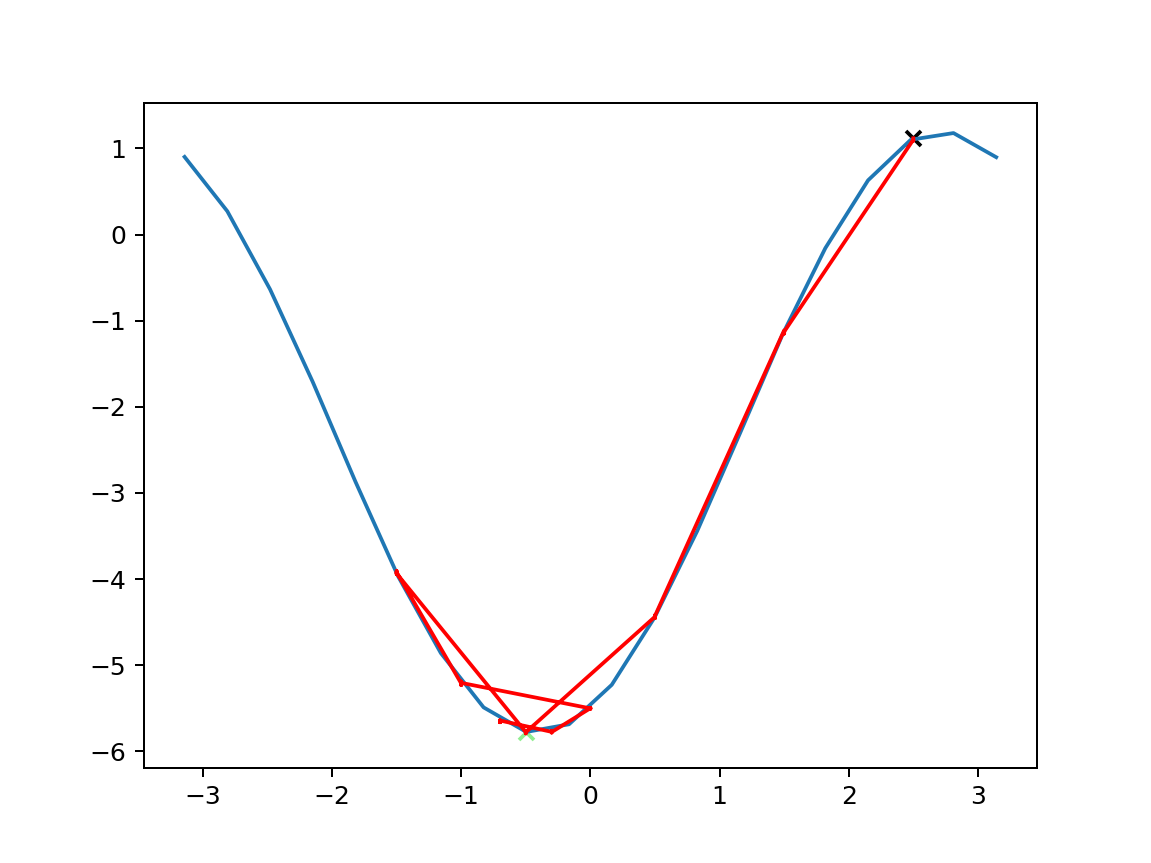

In [10]:
plt.figure()
plt.plot(thetas,E)
plt.plot(theta_store, f_store,color='red')
plt.scatter(theta_store[0],f_store[0], color='black',marker='x')
plt.scatter(res.x[0],res.fun, color='lightgreen',marker='x')


In [11]:
print('Exact ground state energy: ',vqe.get_exact_gs())
print('optimized circuit  energy: ', vqe.objective_function([res.x[0]]))

Exact ground state energy:  5.792849839314598
optimized circuit  energy:  -5.772131999999999


In summary, we prepared a custom Hamiltonian and showed a workflow for adding a custom reference state preparation circuit, custom ansatz circuit and how to perform minimization by brute-force grid evaluation or applying your custom algorithm routines.  